In [1]:
import numpy as np

In [2]:
# Resolve the latest GFS dataset
import metpy
from siphon.catalog import TDSCatalog

# Set up access via NCSS
gfs_catalog = ('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
               'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
cat = TDSCatalog(gfs_catalog)
ncss = cat.datasets[0].subset()

In [3]:
from datetime import datetime, timedelta
from xarray.backends import NetCDF4DataStore
import xarray as xr

# Create a new NCSS query
query = ncss.query()

# Request data in netCDF format
query.accept('netcdf')
var_array=[]
# Ask for our variable
var_names=['Geopotential_height_isobaric','Temperature_isobaric']

for m in np.arange(len(var_names)):
    variable_name=var_names[m]
    query.variables(var_names[m])

# Set the time range of data we want
    now = datetime.utcnow()
    query.time_range(now, now + timedelta(days=0))

# Set the spatial limits
    query.lonlat_box(west=-130, east=-65, north=50, south=25)

    levels=np.arange(1000.e2,50.e2,-50.e2)

    var_array=[] 
    for k in np.arange(levels.size):
        query.vertical_level(levels[k])

# get the data!
        data = ncss.get_data(query)
# We need the datastore so that we can open the existing netcdf dataset we downloaded
        ds = xr.open_dataset(NetCDF4DataStore(data))
        var= ds.metpy.parse_cf(var_names[m])
        var_array=np.append(var_array,var[0,0,:,:],axis=None)
    if(variable_name==var_names[0]):
        hght_array=np.reshape(var_array,(19,51,131))
    else:
        temp_array=np.reshape(var_array,(19,51,131))

In [4]:
latitude = var.metpy.y[::-1]
longitude = var.metpy.x
g=9.8066
omega = 7.292E-5
d2r=np.pi/180.
f0 = 0.5*(2*omega*(np.sin(d2r*latitude[0])+np.sin(d2r*latitude[-1])))
f = 2*omega*np.sin(d2r*latitude)

In [5]:
Phi = g*hght_array[:,::-1,:]
flipped_T = temp_array[:,::-1,:]

In [6]:
num_levs = levels.size
num_lats = var.shape[2]
num_lons = var.shape[3]
print(num_levs,num_lats,num_lons)

19 51 131


In [7]:
def standard_atmosphere(p, p_half):
    g=9.8066
    kappa=0.2856219
    alpha=-1./5.255877
    beta=-6341.624
    gamma=.0065
    R=287.04
    cp = 1004.7
    p00=1000.
    nlevels = p.size
    nlevels_half = p_half.size

    Z = np.zeros(nlevels)
    phi = np.zeros(nlevels)
    T = np.zeros(nlevels)
    theta = np.zeros(nlevels)

    T_half = np.zeros(nlevels)
    theta_half = np.zeros(nlevels_half)
    dthetadp = np.zeros(nlevels_half)
    S = np.zeros(nlevels_half)

    for k in np.arange(nlevels):
        if (p[k] > 226.32):
            Z[k] = (288.15/gamma) * ( 1. - (1013.25/p[k])**alpha)
            T[k] = 288.15 - gamma*Z[k]
            theta[k] = T[k] * (p00/p[k])**(R/cp)
        else:
            T[k] = 216.65
            Z[k] = (11.e3+beta*np.log(p[k]/226.32))
            theta[k] = T[k] * (p00/p[k])**(R/cp)
                
    for k in np.arange(nlevels_half):
        if (p_half[k] > 226.32):
            T_half[k] = 288.15 - gamma*Z[k]
            theta_half[k] = T_half[k] * (p00/p_half[k])**(R/cp)
        else:
            T_half[k] = 216.65
            theta_half[k] = T_half[k] * (p00/p_half[k])**(R/cp)
    
    for k in np.arange(nlevels_half):
        print(k,p_half[k])
        dthetadp[k] = (theta[k+1] - theta[k])/(1.e2*(p[k+1]-p[k]))
        S[k] =  -R*(T_half[k]/theta_half[k])*dthetadp[k]/(p_half[k]*100.)
    return Z, g*Z, T, S

In [8]:
pb = 1000.
pb_half = 975.
pt = 100.
pt_half = 125.
p = np.linspace(pb,pt,19)
p_half = np.linspace(pb_half,pt_half,18)

ZS,phiS,TS,SS=standard_atmosphere(p, p_half)

0 975.0
1 925.0
2 875.0
3 825.0
4 775.0
5 725.0
6 675.0
7 625.0
8 575.0
9 525.0
10 475.0
11 425.0
12 375.0
13 325.0
14 275.0
15 225.0
16 175.0
17 125.0


In [10]:
SS.size

18

In [ ]:
phi_prime=np.zeros([levels.size,num_lats,num_lons])
T_prime=np.zeros([levels.size,num_lats,num_lons])
for k in range(levels.size):
    phi_prime[k,:,:]=Phi[k,:,:]-phiS[k]
    T_prime[k,:,:] = flipped_T[k,:,:]-TS[k]

In [ ]:
def laplacian(longitude,latitude,f):
    d2r=np.pi/180.
    a = 6371.e3
    dlon = a*0.5*d2r
    dlat = a*0.5*d2r
    omega = 7.292E-5
    f0 = 0.5*(2*omega*(np.sin(d2r*latitude[0])+np.sin(d2r*latitude[-1])))
    num_lats=latitude.size
    num_lons=longitude.size
    lat=d2r*latitude

    AC_1=np.zeros([num_lats,num_lons])
    AC_2=np.zeros([num_lats,num_lons])
    AC_3=np.zeros([num_lats,num_lons])
    AC_4=np.zeros([num_lats,num_lons])
    AC_5=np.zeros([num_lats,num_lons])
    AC_6=np.zeros([num_lats,num_lons])
    AC_7=np.zeros([num_lats,num_lons])    

    for j in np.arange(1,num_lats-1):
        latph = d2r*(latitude[j] + .25)
        latmh = d2r*(latitude[j] - .25)
        
        for i in range(1,num_lons-1):
            AC_1[j,i]=np.cos(latmh)/(np.cos(lat[j])*(dlat)**2.)
            AC_2[j,i]=1./( dlon * np.cos(lat[j]) )**2.
            AC_3[j,i]=-(2./( dlon*np.cos(lat[j]) )**2. + (np.cos(latmh)+np.cos(latph))/(np.cos(lat[j])*(dlat)**2.))
            AC_4[j,i]=AC_2[j,i]
            AC_5[j,i]=np.cos(latph)/(((dlat)**2.)*np.cos(lat[j]))
 
    laplacian_piece = [] 
    for m in range(5):
        laplacian_piece.append(np.zeros(f.shape))
    
    laplacian_piece[0][:,1:num_lats-1,1:num_lons-1] = AC_1[1:num_lats-1,1:num_lons-1] * f[:,0:-2, 1:num_lons-1 ]
    laplacian_piece[1][:,1:num_lats-1,1:num_lons-1] = AC_2[1:num_lats-1,1:num_lons-1] * f[:,1:num_lats-1, 0:num_lons-2]
    laplacian_piece[2][:,1:num_lats-1,1:num_lons-1] = AC_3[1:num_lats-1,1:num_lons-1] * f[:,1:-1, 1:-1]
    laplacian_piece[3][:,1:num_lats-1,1:num_lons-1] = AC_4[1:num_lats-1,1:num_lons-1] * f[:,1:-1, 2:num_lons]
    laplacian_piece[4][:,1:num_lats-1,1:num_lons-1] = AC_5[1:num_lats-1,1:num_lons-1] * f[:,2:num_lats, 1:-1]

    laplacian_out = np.zeros([19,num_lats,num_lons])
    laplacian_out = sum(laplacian_piece)
    
    return laplacian_out

In [ ]:
def strat_term(f0,S,num_levels,phip):
    d2r=np.pi/180.
    a = 6371.e3
    dlon = a*0.5*d2r

    dp = 50.e2
    omega = 7.292E-5
    f0 = 0.5*(2*omega*(np.sin(d2r*latitude[0])+np.sin(d2r*latitude[-1])))
    num_lats=latitude.size
    num_lons=longitude.size
    lat=d2r*latitude

    print('MCM, S.size =  ',S.size)

    AC_3=np.zeros([num_levels,num_lats,num_lons])
    AC_6=np.zeros([num_levels,num_lats,num_lons])
    AC_7=np.zeros([num_levels,num_lats,num_lons]) 
    
    for k in np.arange(0,num_levels-1):
        for j in np.arange(1,num_lats-1):
            for i in range(1,num_lons-1):
                AC_3[k,j,i]= -f0*(S[k]+S[k-1])/((dp**2.)*(S[k-1]*S[k]))
                AC_6[k,j,i]=f0/(S[k-1]*dp**2.)
                AC_7[k,j,i]=f0/(S[k]*dp**2.)
    strat=np.zeros([num_levels,num_lats,num_lons])
    strat3=np.zeros([num_levels,num_lats,num_lons])
    strat6=np.zeros([num_levels,num_lats,num_lons])
    strat7=np.zeros([num_levels,num_lats,num_lons])

    for k in np.arange(1,num_levels-1):
        strat3=AC_3[k,:,:]*phip[k,:,:]
        strat6[k,:,:] = AC_6[k,:,:]*phip[k,:,:]
        strat7[k,:,:] = AC_7[k,:,:]*phip[k+1,:,:]
    print(strat3.shape,strat.shape, strat6.shape,strat7.shape)
    strat = strat3+strat6+strat7
    return strat

In [138]:
%%time
qgpv = np.zeros([19,num_lats,num_lons])
T_prime=np.zeros([levels.size,num_lats,num_lons])
for j in np.arange(1,num_lats-1):
    for i in range(1,num_lons-1):
        qgpv[9:11,j,i] =1.e-5*np.exp((-(((i-67)**2)+(j-27)**2.)/50.))
T_prime[1,:] = 0.0
T_prime[-1,:] = 0.0

CPU times: user 81.4 ms, sys: 2 µs, total: 81.4 ms
Wall time: 78.8 ms


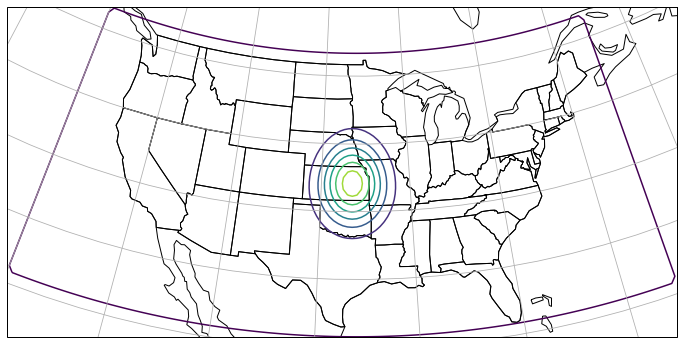

In [139]:
###%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# GFS uses lon/lat grid
data_projection = ccrs.PlateCarree()

# Make it easy to change what time step we look at
t_step = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
#mesh = ax.pcolormesh(longitude, latitude, phip[10,:],transform=data_projection, zorder=0)


ax.contour(longitude,latitude,qgpv[10,:,:],transform=data_projection)

#ax.contour(longitude,latitude,phi_prime[10,:,:],transform=data_projection, colors='black')

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

# add a colorbar
#cax = fig.colorbar(mesh)
#cax.set_label(var.attrs['units'])

In [140]:
R=287.04
#specify Neumann boundary conditions (theta at bottom and top)
qgpv[0,:]=-R*0.5*(T_prime[0,:]/(1.e2*p[0])+T_prime[1,:]/(1.e2*p[1]))
qgpv[-1,:]=-R*0.5*(T_prime[-2,:]/(1.e2*p[-2])+T_prime[-1,:]/(1.e2*p[-1]))

In [148]:
%%time
#Laplacian coefficient
phip = np.zeros([num_levs,num_lats,num_lons])
res = np.zeros([num_levs,num_lats,num_lons])
d2r=np.pi/180.
a = 6371.e3
dlon = a*0.5*d2r
dlat = a*0.5*d2r
dp = 50.e2
omega = 7.292E-5
f0 = 0.5*(2*omega*(np.sin(d2r*latitude[0])+np.sin(d2r*latitude[-1])))
num_lats=latitude.size
lat=d2r*latitude

sigma = (dlon/dlat)
sigma_squared = sigma*sigma

AC_1=np.zeros([num_lats])
AC_2=np.zeros([num_lats])
AC_3=np.zeros([num_levs,num_lats])
AC_4=np.zeros([num_lats])
AC_5=np.zeros([num_lats])
AC_6=np.zeros([num_levs])
AC_7=np.zeros([num_levs])

for k in np.arange(1,num_levs-1):
    AC_6[k]=f0/(SS[k-1]*dp**2.)
    AC_7[k]=f0/(SS[k]*dp**2.)
for k in np.arange(0,num_levs-1):
    for j in np.arange(1,num_lats-1):
        latph = d2r*(latitude[j] + .25)
        latmh = d2r*(latitude[j] - .25)
        
        AC_1[j]=np.cos(latmh)/(np.cos(lat[j])*(dlat)**2.)
        AC_2[j]=1./( dlon * np.cos(lat[j]) )**2.
        #AC_3[k,j]=-(AC_6[k]+AC_7[k])
        AC_3[k,j]=-(AC_6[k]+AC_7[k])-(2./( dlon*np.cos(lat[j]) )**2. + (np.cos(latmh)+np.cos(latph))/(np.cos(lat[j])*(dlat)**2.))
        AC_4[j]=AC_2[j]
        AC_5[j]=np.cos(latph)/(np.cos(lat[j])*(dlat)**2.)

AC_1 = dlon*dlon*AC_1        
AC_2 = dlon*dlon*AC_2        
AC_3 = dlon*dlon*AC_3        
AC_4 = dlon*dlon*AC_4        
AC_5 = dlon*dlon*AC_5        
AC_6 = dlon*dlon*AC_6        
AC_7 = dlon*dlon*AC_7        

print('got here!')

for iter in range(100):
    for k in np.arange(1,num_levs-1):
        for j in np.arange(1,num_lats-2):
            for i in np.arange(1,num_lons-2):
                res[k,j,i] = AC_1[j]*phip[k,j-1,i] + AC_2[j]*phip[k,j,i-1] + AC_3[k,j]*phip[k,j,i] + AC_4[j]*phip[k,j,i+1] + AC_5[j]*phip[k,j+1,i]+ AC_6[k]*phip[k-1,j,i]+ AC_7[k]*phip[k+1,j,i]-qgpv[k,j,i]*dlon*dlon
                phip[k,j,i] = phip[k,j,i] - 1.7*res[k,j,i]/AC_3[k,j]
                if(k==1): 
                    phip[0,j,i] = phip[1,j,i]
                if(k==num_levs-2): 
                    phip[-1,j,i] = phip[-2,j,i]
    3print(phip[:,27,67])
    #print(iter)

got here!
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.          -5.69050164
 -12.03427174 -11.25498665 -10.64561667 -10.21430416  -9.98567632
 -12.79520849 -15.2151433  -17.12986443 -17.12986443]
[  0.           0.           0.           0.           0.
   0.           0.           0.          -4.47204552 -15.20865156
 -21.13402763 -20.02811668 -19.19461615 -18.66111123 -20.49456339
 -23.67054696 -26.2388122  -27.37421017 -27.37421017]
[  0.           0.           0.           0.           0.
   0.           0.          -3.5365365  -12.0546049  -22.6199195
 -28.41627497 -27.23531152 -26.3971291  -27.43992242 -29.57603808
 -32.30817054 -34.02576165 -34.84536644 -34.84536644]
[  0.           0.           0.           0.           0.
   0.          -2.81167546  -9.6137059  -18.12652359 -28.69848714
 -34.52483129 -33.4112325  -33.81668875 -35.13818836 -36.98432644
 -39.0142996  -40.36466016 -41.03697333 -41.03697333]
[  0.          

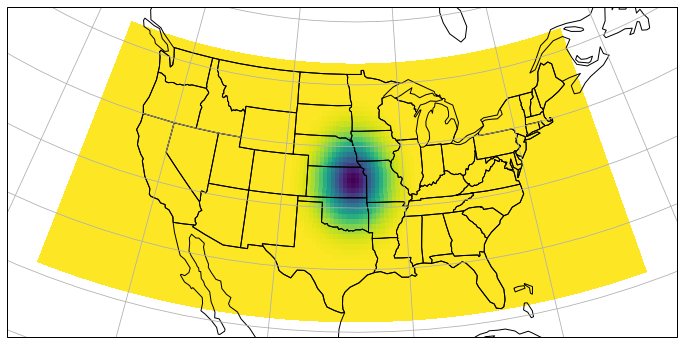

In [149]:
###%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# GFS uses lon/lat grid
data_projection = ccrs.PlateCarree()

# Make it easy to change what time step we look at
t_step = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())
mesh = ax.pcolormesh(longitude, latitude, phip[2,:],transform=data_projection, zorder=0)


#ax.contour(longitude,latitude,phip[10,:,:],levels=(-900,-100,-60,-30,-15,-5,-1),transform=data_projection)

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

# add a colorbar
#cax = fig.colorbar(mesh)
#cax.set_label(var.attrs['units'])

In [143]:
print(phip[:,27,67])

[-249.32448571 -249.32448571 -252.73174145 -256.86818843 -261.83099227
 -267.74186386 -274.75543736 -283.0713643  -292.95221447 -304.75074452
 -311.65782684 -311.4621871  -311.46651043 -311.68286408 -312.13130484
 -312.84763085 -313.26635095 -313.39753173 -313.39753173]


In [ ]:
p[levels[-1]]

In [ ]:
b=np.array([1,2,3,4])

In [ ]:
c=np.array([-1,1,-1,1])

In [ ]:
print(c[0:2],b[1:3], c[0:2]*b[1:3])

In [ ]:
num_lats=latitude.size
num_lons=longitude.size
print(num_lats,num_lons)    

In [ ]:
print(var)

In [ ]:
print(qgpv_s.shape,phi_prime.shape)

In [ ]:
for k in np.arange(1,4):
    print(k, num_lats)

In [ ]:
qgpv.shape

In [ ]:
i = np.arange(11)
f = np.exp((-(i-5)**2)/4)
print(f)

In [ ]:
np.average(longitude)


In [111]:
for k in np.arange(0,num_levs-1):
    print(k,AC_7[k],SS[k],p_half[k])


0 12998.42183059245 8.244885241214767e-07 975.0
1 11816.87632818079 9.069274597937207e-07 925.0
2 10685.941834959349 1.0029110953938037e-06 875.0
3 9606.156363038886 1.1156438877311006e-06 825.0
4 8578.095833764019 1.2493506529538239e-06 775.0
5 7602.379304220733 1.4096967807254238e-06 725.0
6 6679.675314209577 1.6044267313735035e-06 675.0
7 5810.709692062357 1.844361566652252e-06 625.0
8 4996.275294092884 2.1450078308704013e-06 575.0
9 4237.244360057021 2.529249842666457e-06 525.0
10 3534.584492804664 3.0320535986139805e-06 475.0
11 2889.3798004096952 3.7091176554546225e-06 425.0
12 2302.859638954795 4.653800626718929e-06 375.0
13 1776.4390009333567 6.032883552648146e-06 325.0
14 1311.7776441003978 8.16986756803832e-06 275.0
15 427.7097439206269 2.5056828335906213e-05 225.0
16 182.878201992084 5.860211613124591e-05 175.0
17 92.3887967959781 0.0001159994501787915 125.0


In [33]:
num_levs-1

18

[]

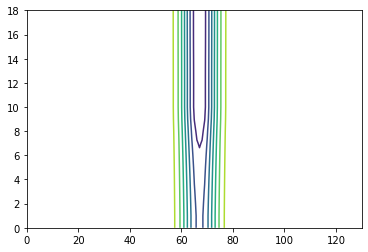

In [150]:
X = np.arange(0,num_lons)
Y = np.arange(0,num_levs)
ax = fig.add_subplot(2, 1, 1)
plt.contour(X, Y, phip[:,27,:])
plt.plot()

In [152]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr

import metpy.calc as mpcalc
from metpy.interpolate import cross_section

In [ ]:
QGPV = xr.DataArray(qgpv,coords=)